# The Position History Data

Probably the most critical auxiliary file GBM produces is the position history (POSHIST) file.  The POSHIST contains, for an entire day, the spacecraft location in orbit and pointing information, sampled on a 1 second timescale.  If you are just interested in triggered GRB analysis where all of the response files are already made for you, then POSHIST may not be of much interest.  But if you are using the continuous data in any way, the POSHIST is your dearest friend.  You may want to know if a source is visible at a particular time (i.e. not behind the Earth), and if it is, what is the closest detector to the source.  You may want to know if there are specific contributions to the background during a time interval, such as sun visibility or high geomagnetic latitude in orbit.  You may want to rotate something from the equatorial frame to the Fermi inertial frame, or vice versa.  Or you may want to make a [pretty gif](https://fermi.gsfc.nasa.gov/fermi10/fridays/04132018.html) of the detector pointings over time.

To read a POSHIST file:

In [1]:
from gbm import test_data_dir
from gbm.data import PosHist

# open a poshist file
poshist = PosHist.open(test_data_dir+'/glg_poshist_all_170101_v00.fit')
print(poshist)

glg_poshist_all_170101_v00.fit


An important thing you should check is the time coverage of the POSHIST to ensure it is the file you need.  The times are listed in Fermi Mission Elapsed Time (MET).

In [2]:
poshist.time_range

(504921540.740104, 505008061.340078)

This seems like a good *time* for a brief aside about MET and time conversions.  Sometimes you don't know the MET corresponding to the time you're interested in, or you're not sure what a given MET really means.  There is a nice utility class in `gbm.time` that will allow you to do various time coversions to/from MET.   Let's see what poshist ``time_range`` is in UTC: 

In [3]:
from gbm.time import Met
[Met(t).iso() for t in poshist.time_range]

['2016-12-31T23:58:56', '2017-01-02T00:00:56']

Similarly, you can use the ``Met`` class to go *from* some time convention or epoch *to* MET.  This is useful because many of the functions and classes in the Data Tools use the MET:

In [4]:
met = Met.from_iso('2017-01-01T14:58:15')
met.met

504975500.0

Ok, back to the position history!

The POSHIST also contains information about good time intervals (GTI).  GTIs are intervals when the GBM detectors were operational and observing.  Mostly non-operational times are when Fermi is passing through the South Atlantic Anomaly (SAA).  The listing of GTIs in the POSHIST is an attribute:

In [5]:
poshist.gti

[(504921540.740104, 504924818.340072),
 (504925227.340079, 504962247.340076),
 (504963081.340078, 504967992.340078),
 (504969383.340077, 504973833.340077),
 (504975419.340078, 504979728.340076),
 (504981395.340078, 504985767.340077),
 (504987345.340078, 504991938.340124),
 (504993281.340069, 504998034.340079),
 (504999211.340076, 505004088.340077),
 (505005126.34007, 505008061.340078)]

Let's say we are interested in data around a specific time, for example MET=504975500.  We can query the ```PosHist``` object for various things, such as where Fermi was in orbit at that particular time:

In [6]:
t0 = 504975500.0

lat = poshist.get_latitude(t0)
lon = poshist.get_longitude(t0) # note: East longitude
alt = poshist.get_altitude(t0) # in meters
print('Latitude: {:.2f}'.format(lat))
print('Longitude: {:.2f}'.format(lon))
print('Altitude: {:.2f} m'.format(alt))

Latitude: -23.43
Longitude: 26.52
Altitude: 544568.92 m


You can check to see if Fermi was in the SAA at that time:

In [7]:
poshist.get_saa_passage(t0)

array(False)

You might be interested to know where the Earth is (and its apparent radius) relative to Fermi:

In [8]:
geocenter = poshist.get_geocenter_radec(t0)
georadius = poshist.get_earth_radius(t0)
print("Geocenter RA, Dec = {0:.2f}, {1:.2f}".format(*geocenter))
print('Earth radius: {:.2f} deg'.format(georadius))

Geocenter RA, Dec = 172.53, 23.43
Earth radius: 67.11 deg


It might be useful to know if the sun is visible.  Perhaps you're interested in looking for solar emission or you're worried about noise contributions from the sun:

In [9]:
poshist.get_sun_visibility(t0)

array(True)

For that matter, you could be interested in a particular known source, and it would be pretty helpful to know if it is even visible to Fermi at the time of interest:

In [10]:
# the position of our source
ra = 324.3
dec = -20.8
poshist.location_visible(ra, dec, t0)

array([ True])

Well, that's good to know.  But we want to look at the data for the closest detector to that position.  We can figure that out.  Where is detector 'n0' pointing?

In [11]:
poshist.detector_pointing('n0', t0)

(array(327.88023524), array(-18.18014898))

Ooh, we got lucky; that's pretty close to our source position! What's the detector-source angle?

In [12]:
poshist.detector_angle(ra, dec, 'n0', t0)

4.2721980564266975

Sometimes it's useful to transform a source location of interest in equatorial coordinates to the Fermi inertial frame. You can do that by

In [13]:
poshist.to_fermi_frame(ra, dec, t0)

(array(39.67934005), array(24.14464044))

It's important to note that the Fermi inertial frame is defined by azimuth (0-360 deg) and zenith (0-180 deg). Here, azimuth=0 is approximately the pointing of detector NaI 5, and increases counter-clockwise when looking down the LAT boresight.   Zenith=0 is defined as the LAT boresight, and zenith=180 is directly below the spacecraft.

You can also go from Fermi (azimuth, zenith) coordinates to equatorial coordinates:

In [14]:
# and where is the Fermi zenith (LAT boresight) in equatorial coordinates?
poshist.to_equatorial(0.0, 0.0, t0)

(array(333.15399016), array(1.73430464))

You probably noticed that many of the outputs to these functions are returned as arrays.  That is because instead of just defining a single time of interest, you can provide an array of times, and easily calculate any of these properties.

Now all of this great, but can we make a pretty plot?  Yep.  Use the ``SkyPlot`` (Equatorial Coordinates) or ``FermiSkyPlot`` (Fermi Inertial Coordinates) class in the ```gbm.plot``` module:

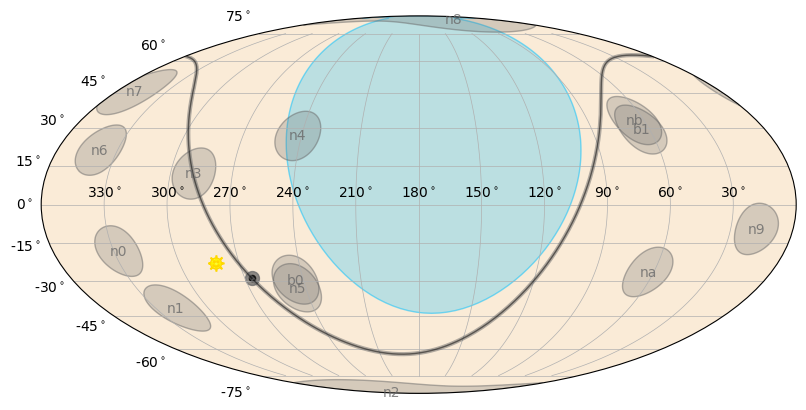

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from gbm.plot import SkyPlot, FermiSkyPlot

# initialize plot
skyplot = SkyPlot()
# plot the orientation of the detectors and Earth blockage at our time of interest
skyplot.add_poshist(poshist, trigtime=t0)
plt.show()

Woah!  So there's a lot going on here.  First of all, there is a big blue blob in the middle of the plot; that's the Earth as observed by Fermi.  So nothing behind that is visible.  The curved gray line going through the plot demarcates the Galactic Plane, and the dot is the Galactic Center.  All of the gray labeled circles are the GBM detector pointings.  Note these are **not** representative of the field-of-view (FoV) of the detectors (their FoV is virtually the whole sky).  But they do allow you to visualize where the effective area of each detector is near its maximum.  Finally, the yellow smiley-face is the sun.

The ```FermiSkyPlot``` class does the plot in Fermi inertial coordinates:

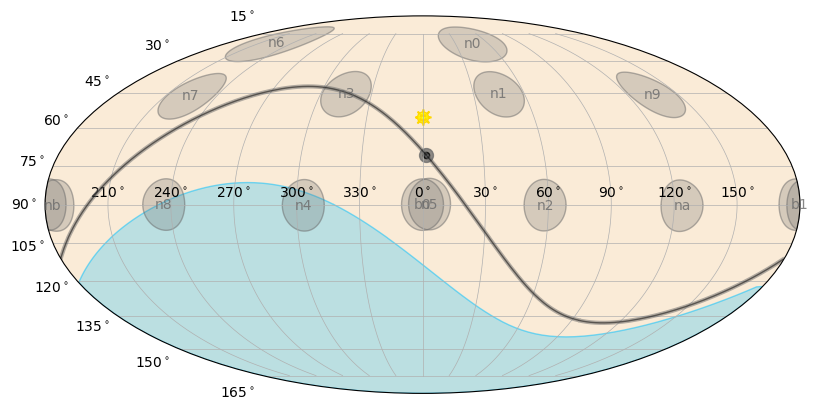

In [16]:
fermiplot = FermiSkyPlot()
fermiplot.add_poshist(poshist, trigtime=t0)
plt.show()

And to finish off our plotting fun, we can plot where Fermi is in orbit during our time of interest using the ```EarthPlot``` class:

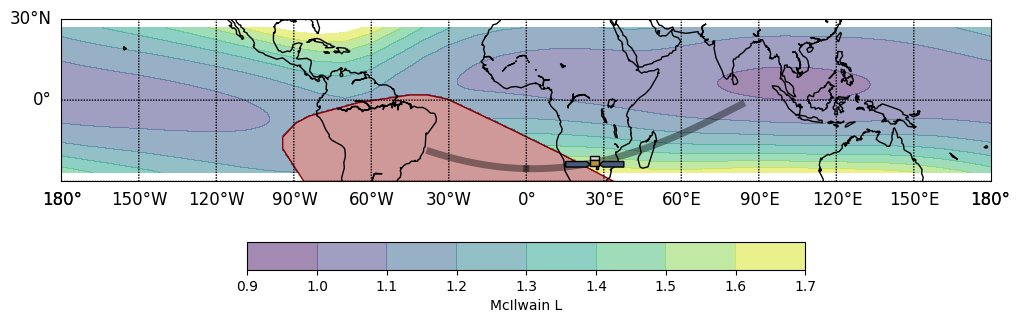

In [17]:
from gbm.plot import EarthPlot

# initialize plot
earthplot = EarthPlot()

# let's show the orbital path for +/-1000 s around our t0
earthplot.add_poshist(poshist, trigtime=t0, time_range=(t0-1000.0, t0+1000.0))

Whew, our time of interest was just *after* Fermi exited the SAA (red shaded region).  You can see the Fermi orbital path in gray, and the colored contours represent the McIlwain L (proxy for geomagnetic latitude).  Fermi's location relative to the McIlwain L contours is important, because higher backgrounds and local particle flux trapped in the geomagnetic field are more likely an issue towards the higher end of this scale.

Finally, you could be interested in some long period of time, or a period that crosses the day boundary, and therefore you need to use more than one POSHIST file.  The ```PosHist``` class has a method specifically for this case.  You can *merge* multiple ```PosHist``` objects into one object following:
```python
merged_poshists = PosHist.merge([poshist1, poshist2, ...])
```
And then you can easily use all of the functionality we've discussed here.

That's it for the position history data, so if you're interested in understanding the trigger quicklook data, [continue](./Trigdat.ipynb) on!